In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import math
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import matplotlib.pyplot as plt

# File path for the shapefile
file_path = "ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"

# Load the dataset
world = gpd.read_file(file_path)

# Filter and extract necessary columns
world = world[['NAME', 'geometry']].dropna()
world = world.rename(columns={'NAME': 'name'})

# Simplify coordinates to centroids
world['centroid'] = world['geometry'].centroid
world['lon'] = world['centroid'].x
world['lat'] = world['centroid'].y

# Extract necessary data into a DataFrame
country_data = pd.DataFrame({
    'country': world['name'],
    'lon': world['lon'],
    'lat': world['lat']
})

# Add North Pole as a special entry at the start
north_pole = pd.DataFrame({
    'country': ['North Pole'],
    'lon': [0.0],        # Arbitrary, longitude is irrelevant at the pole
    'lat': [90.0]
})
country_data = pd.concat([north_pole, country_data], ignore_index=True)

C:\Users\renat\AppData\Local\Temp\ipykernel_17716\3908369373.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  world['centroid'] = world['geometry'].centroid


In [2]:
# Haversine function to compute great circle distances
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    R = 6371  # Radius of earth in kilometers
    return R * c

In [3]:
# Build the distance matrix
locations = country_data[['lat', 'lon']].values
num_locations = len(locations)
distance_matrix = np.zeros((num_locations, num_locations))

for i in range(num_locations):
    for j in range(num_locations):
        if i == j:
            distance_matrix[i, j] = 0
        else:
            lat1, lon1 = locations[i]
            lat2, lon2 = locations[j]
            distance_matrix[i, j] = haversine_distance(lat1, lon1, lat2, lon2)

In [4]:
# OR-Tools TSP Solver
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = distance_matrix.astype(int).tolist()
    data['num_vehicles'] = 1
    data['depot'] = 0  # North Pole as start/end
    return data

data = create_data_model()
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])
routing = pywrapcp.RoutingModel(manager)

In [5]:
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Setting first solution heuristic
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

# Solve the problem
solution = routing.SolveWithParameters(search_parameters)

Route: North Pole -> Greenland -> Iceland -> Norway -> Sweden -> Finland -> Estonia -> Latvia -> Lithuania -> Belarus -> Ukraine -> Moldova -> Romania -> Bulgaria -> Turkey -> Georgia -> Armenia -> Azerbaijan -> Turkmenistan -> Uzbekistan -> Kazakhstan -> Kyrgyzstan -> Tajikistan -> Nepal -> Bhutan -> Bangladesh -> Myanmar -> China -> Mongolia -> Russia -> North Korea -> Japan -> South Korea -> Taiwan -> Philippines -> Vietnam -> Laos -> Thailand -> Cambodia -> Malaysia -> Brunei -> Indonesia -> Timor-Leste -> Australia -> Papua New Guinea -> Solomon Is. -> Vanuatu -> Fiji -> New Caledonia -> New Zealand -> Antarctica -> Fr. S. Antarctic Lands -> Sri Lanka -> India -> Pakistan -> Afghanistan -> Iran -> Qatar -> United Arab Emirates -> Oman -> Yemen -> Saudi Arabia -> Kuwait -> Iraq -> Syria -> N. Cyprus -> Cyprus -> Lebanon -> Jordan -> Palestine -> Israel -> Egypt -> Greece -> North Macedonia -> Albania -> Montenegro -> Kosovo -> Serbia -> Hungary -> Slovakia -> Poland -> Denmark -> U

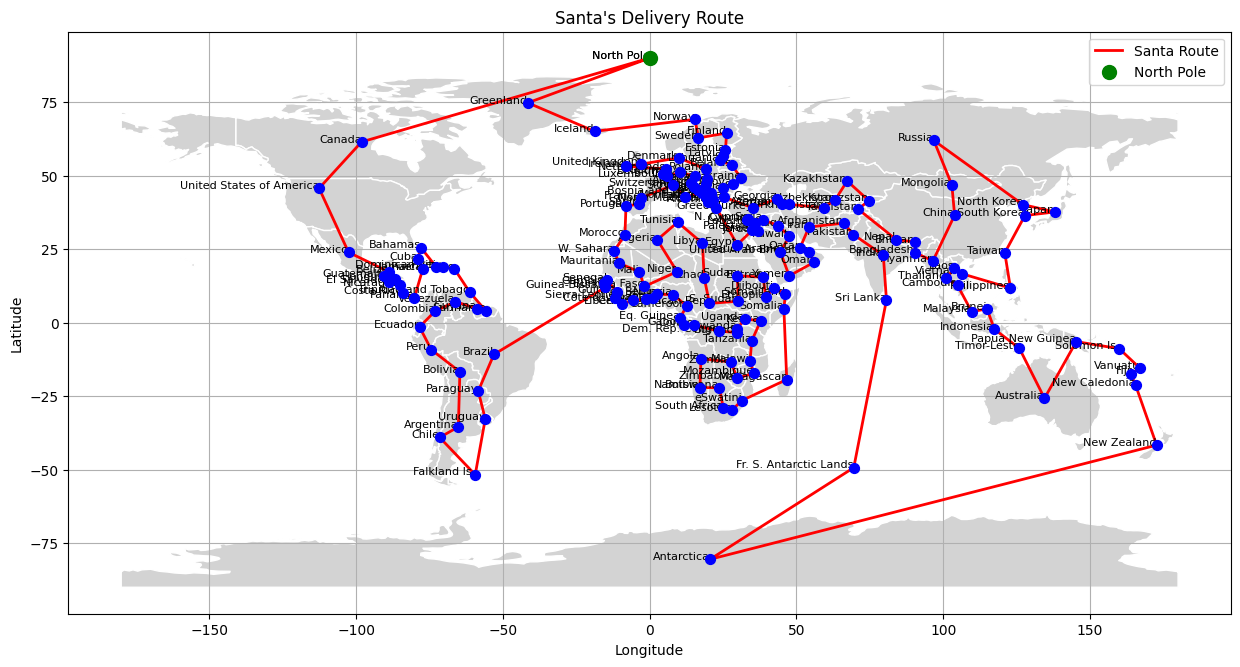

In [6]:
if solution:
    # Extract the route
    index = routing.Start(0)
    route = []
    while not routing.IsEnd(index):
        route.append(manager.IndexToNode(index))
        index = solution.Value(routing.NextVar(index))
    route.append(manager.IndexToNode(index))  # return to North Pole

    # Print route (Optional)
    route_countries = country_data.iloc[route]['country'].values
    print("Route:", " -> ".join(route_countries))

    # Plotting
    # Plot the world
    fig, ax = plt.subplots(figsize=(15,8))
    world.plot(ax=ax, color='lightgrey', edgecolor='white')

    # Extract lat/lon for the route
    route_points = country_data.iloc[route][['lon', 'lat']].values
    
    # Plot the route lines
    plt.plot(route_points[:,0], route_points[:,1], 'r-', linewidth=2, label='Santa Route')
    # Plot the points
    plt.scatter(route_points[:,0], route_points[:,1], c='blue', s=50, zorder=5)
    
    # Mark North Pole specifically
    plt.scatter(route_points[0,0], route_points[0,1], c='green', s=100, zorder=6, label='North Pole')
    
    # Add labels or tooltips if desired
    for idx, row in country_data.iloc[route].iterrows():
        plt.text(row['lon'], row['lat'], row['country'], fontsize=8, ha='right')
    
    plt.title('Santa\'s Delivery Route')
    plt.legend()
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

else:
    print("No solution found!")

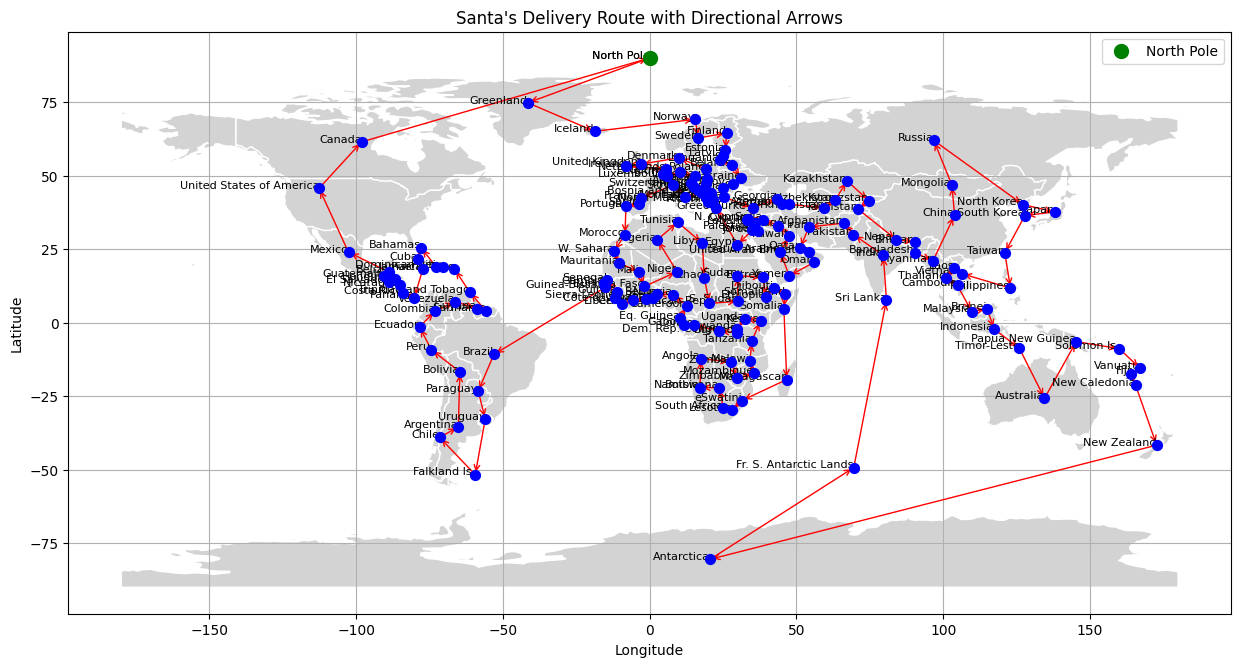

In [7]:
# Plotting
fig, ax = plt.subplots(figsize=(15,8))
world.plot(ax=ax, color='lightgrey', edgecolor='white')

route_points = country_data.iloc[route][['lon', 'lat']].values

# Instead of a single continuous line, draw small arrows from each point to the next
for i in range(len(route_points)-1):
    start_lon, start_lat = route_points[i]
    end_lon, end_lat = route_points[i+1]
    # Draw an arrow from start to end
    plt.annotate(
        '', 
        xy=(end_lon, end_lat), 
        xytext=(start_lon, start_lat),
        arrowprops=dict(arrowstyle="->", color='red', lw=1)
    )

# Plot the points as well (countries + North Pole)
plt.scatter(route_points[:,0], route_points[:,1], c='blue', s=50, zorder=5)

# Highlight the North Pole
plt.scatter(route_points[0,0], route_points[0,1], c='green', s=100, zorder=6, label='North Pole')

# Add labels to each visited location
for idx, row in country_data.iloc[route].iterrows():
    plt.text(row['lon'], row['lat'], row['country'], fontsize=8, ha='right')

plt.title('Santa\'s Delivery Route with Directional Arrows')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()
